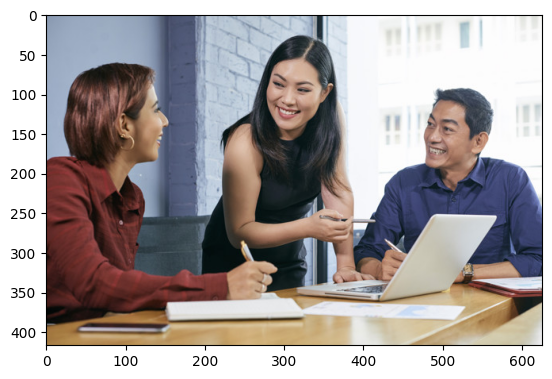

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

IMAGE_PATH = 'images/objects/smartphones.jpg'

FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.9
THICKNESS = 1

BLACK  = (0,0,0)
BLUE   = (255,178,50)
YELLOW = (0,255,255)


def cv2_imshow(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)


def draw_label(im, label, x, y):
    """Draw text onto image at location."""
    # Get text size.
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]
    # Use text size to create a BLACK rectangle.
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, label, (x, y + dim[1]), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv2.LINE_AA)


def get_coco_classes(path):
    with open(path, 'rt') as f:
        return f.read().rstrip('\n').split('\n')


img = cv2.imread(IMAGE_PATH)
cv2_imshow(img)

In [2]:
model = 'models/yolo/yolov5s.onnx'
net = cv2.dnn.readNetFromONNX(model)
blob = cv2.dnn.blobFromImage(img, 1/255, (640, 640))
net.setInput(blob)

# 25200 bounding boxes
# every bounding boxes has 85 columns (x, y, w, h, confidence, 80 object classes)
output = net.forward()
print(output.shape)

(1, 25200, 85)


laptop 457.85248 476.64227 218.70535 158.79773 [340 388 213 155]
laptop 465.19455 469.89307 226.66235 167.54678 [344 377 221 163]
laptop 446.77048 487.53354 211.90028 134.77213 [333 410 207 131]
laptop 589.21277 526.4549 100.50242 39.235615 [527 495  98  38]
laptop 457.3638 476.51746 213.97916 157.58269 [342 389 209 154]
laptop 465.04156 469.99576 221.33354 175.89058 [346 373 216 172]
laptop 446.02487 487.31348 211.20457 131.66846 [332 412 206 128]
laptop 449.2656 468.62347 262.21548 164.78293 [311 377 256 161]
laptop 455.60352 469.34766 260.75204 167.88268 [318 376 255 164]
laptop 457.99442 470.1183 257.2182 171.387 [322 376 251 167]
laptop 590.4492 525.8833 98.881454 38.506805 [529 495  96  37]
person 303.44928 291.1976 197.93527 495.56775 [200  42 193 484]
person 299.98737 289.0437 199.11716 503.05167 [196  36 194 492]
person 520.88245 328.15768 236.78188 358.82492 [393 145 231 350]
person 135.49036 352.60864 275.7158 520.12036 [ -2  90 269 508]
person 516.4605 331.72208 247.59915 3

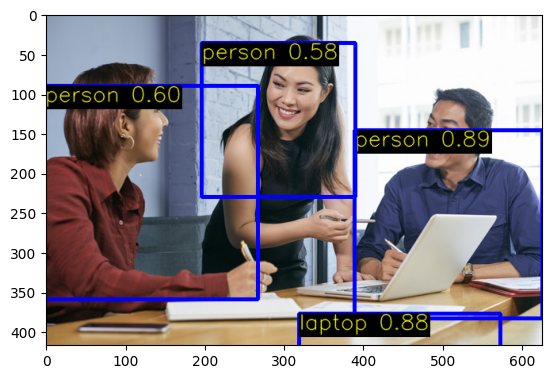

In [3]:
INPUT_WIDTH = INPUT_HEIGHT = 640

CX = 0
CY = 1
W = 2
H = 3
CONFIDENCE = 4


THRESHOLD_CONFIDENCE = 0.40
THRESHOLD_SCORE = 0.5
THRESHOLD_NMS = 0.50

bboxes = output[0]

h, w, _ = img.shape

x_factor = w / INPUT_WIDTH
y_factor = w / INPUT_HEIGHT

classes = get_coco_classes("models/coco.names")

class_ids = list()
confidences = list()
selected_bboxes = list()

for bbox in bboxes:
    if bbox[CONFIDENCE] < THRESHOLD_CONFIDENCE:
        continue

    classes_score = bbox[CONFIDENCE+1:]
    class_id = np.argmax(classes_score)

    if classes_score[class_id] < THRESHOLD_SCORE:
        continue

    confidences.append(bbox[CONFIDENCE])
    class_ids.append(class_id)

    cx, cy, w, h = bbox[CX], bbox[CY], bbox[W], bbox[H]
    left = int((cx - w/2) * x_factor)
    top = int((cy - h/2) * y_factor)
    width = int(w * x_factor)
    height = int(h * y_factor)
    box = np.array([left, top, width, height])
    selected_bboxes.append(box)
    print(classes[class_id], cx, cy, w, h, box)

indices = cv2.dnn.NMSBoxes(selected_bboxes, confidences, THRESHOLD_CONFIDENCE,
                           THRESHOLD_NMS)

BLUE = (255, 0, 0)
THICKNESS = 1



for i in indices:
    bbox = selected_bboxes[i]
    left, top, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
    label = "{} {:.2f}".format(classes[class_ids[i]], round(confidences[i], 2))
    cv2.rectangle(img, (left, top), (left+width, top+width), BLUE, 3*THICKNESS)
    draw_label(img, label, left, top)

cv2_imshow(img)

print(indices)